[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

# Sub-graphs

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

We just covered parallelization, which is one important LangGraph controllability topic.

## Goals

Now, we're [going to cover sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example).

## State

Sub-graphs allow you to create and manage different states in different parts of your graph. 

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate! 

In short, communication is **done with over-lapping keys**: 

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

Let's define a schema for the logs that will be input to our graph.

In [1]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Sub graphs

Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

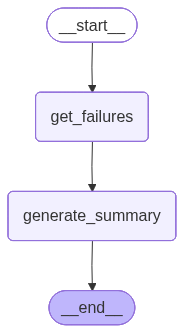

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Here is the question summarization sub-grap, which uses `QuestionSummarizationState`.

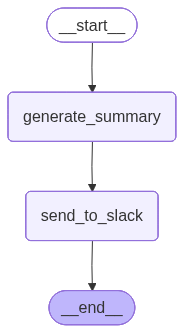

In [5]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph

Now, we can bring it all together.

We create our parent graph with `EntryGraphState`. 

And we add our sub-graphs as nodes! 

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

In [6]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output `cleaned_logs`.

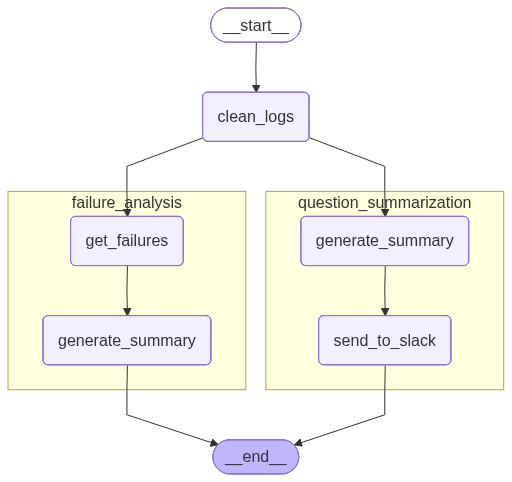

In [7]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r

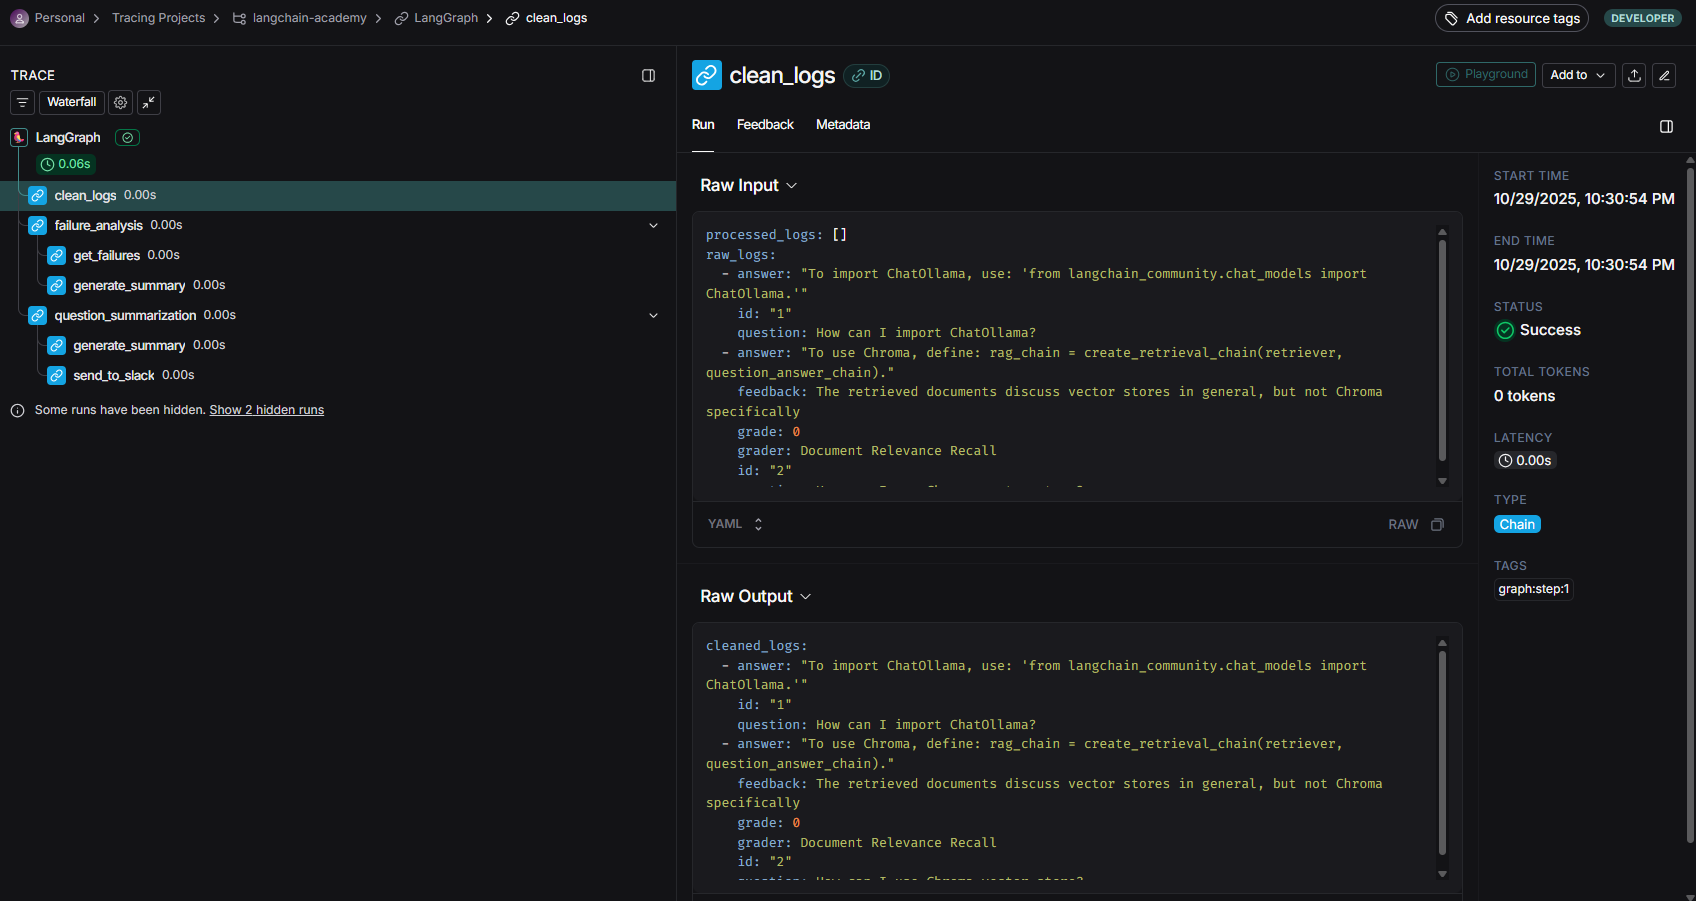

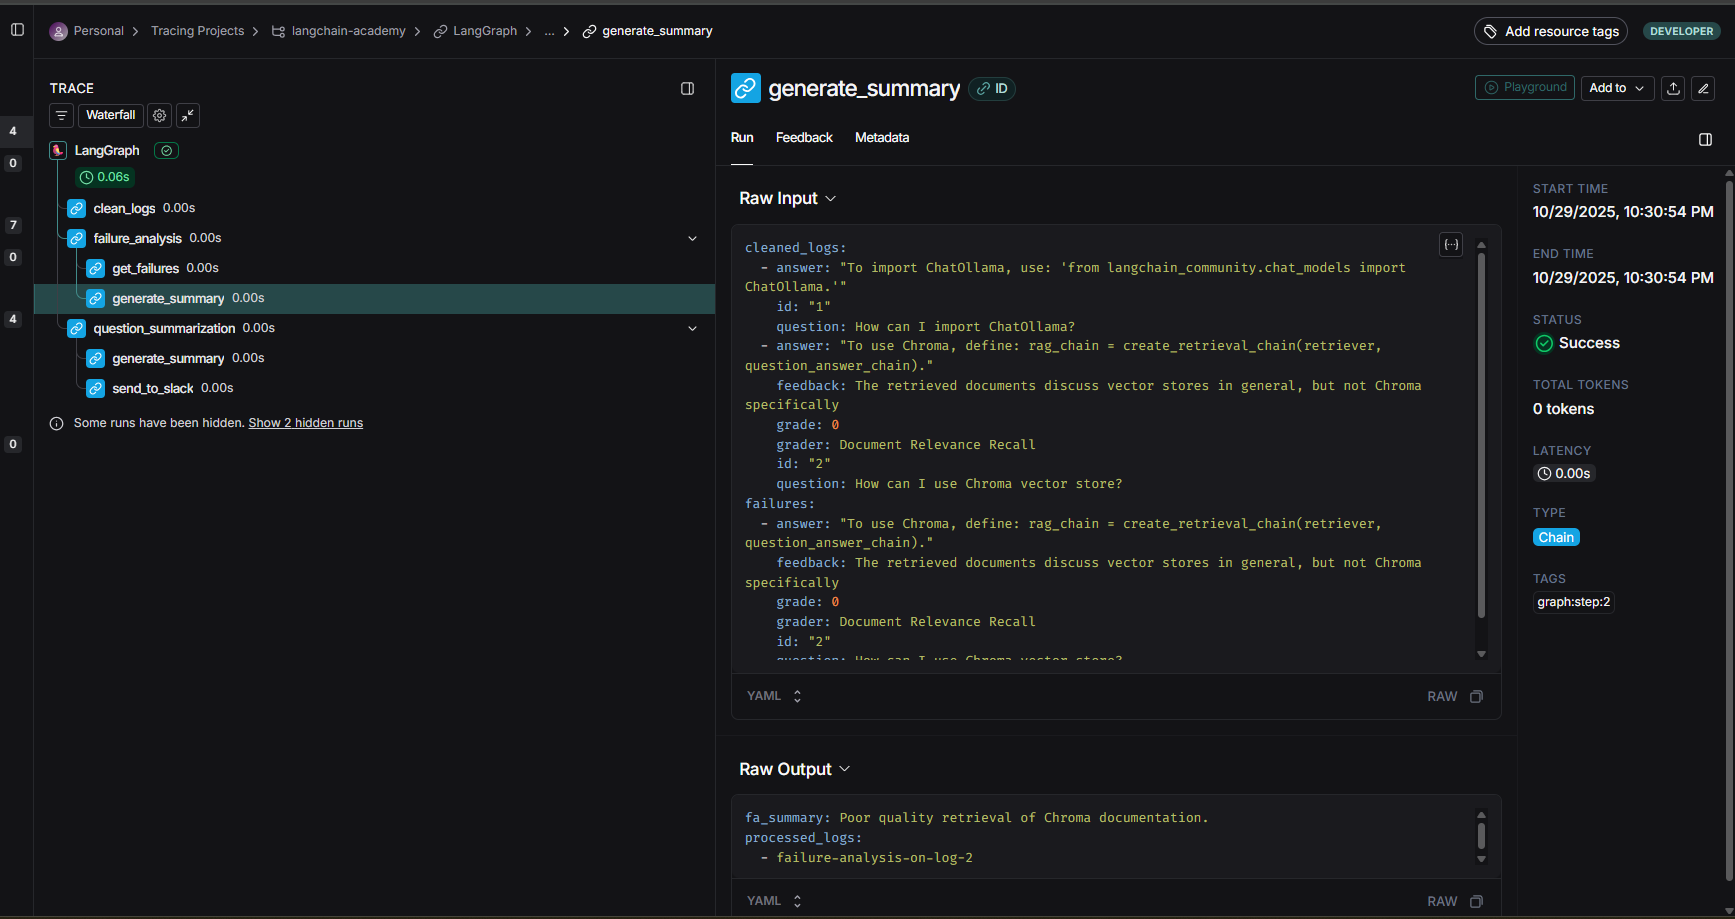

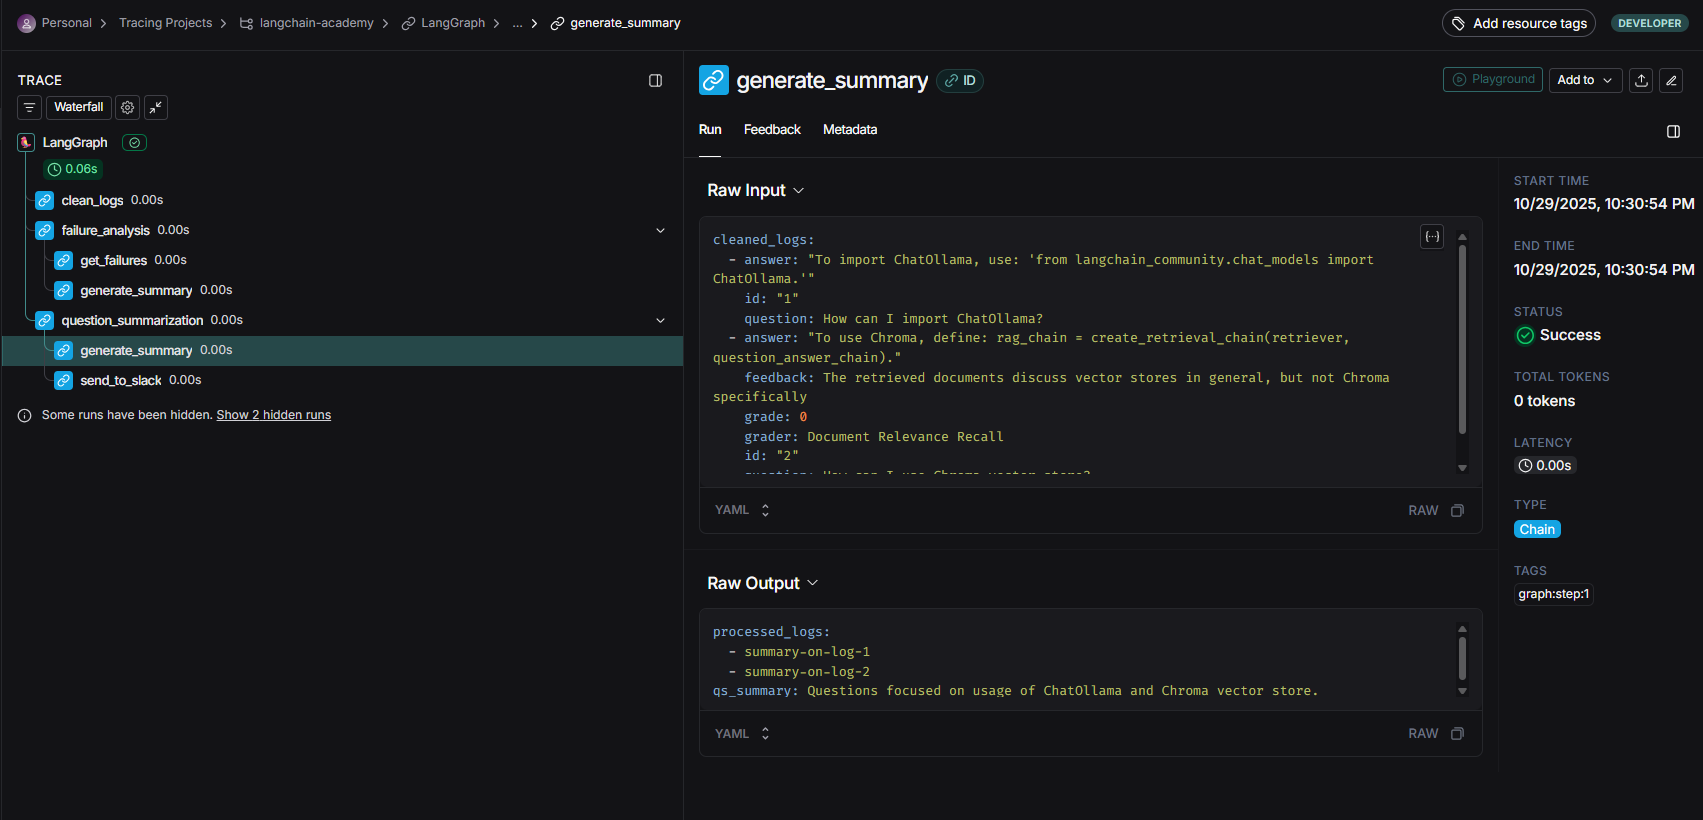

Graph visualization:

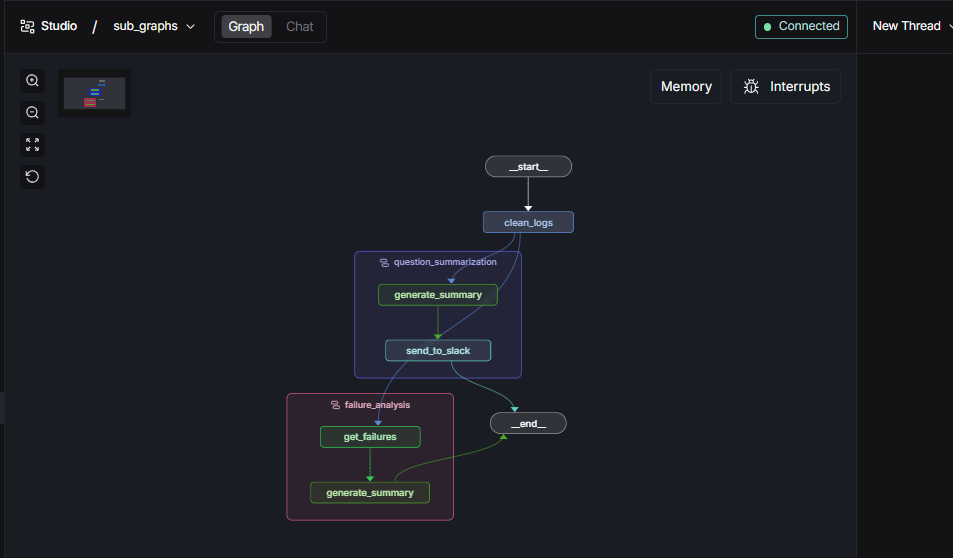

# MY EXAMPLES:

Define the state schemas:

In [9]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

class Ticket(TypedDict):
    id: str
    customer: str
    issue: str
    urgency: Optional[str]
    response: Optional[str]
    notes: Optional[str]


# Parent graph state
class EntryGraphState(TypedDict):
    raw_tickets: List[Ticket]
    cleaned_tickets: List[Ticket]
    urgency_summary: str   # from UrgencyAnalysisGraph
    response_summary: str  # from ResponseGenerationGraph
    processed_logs: Annotated[List[str], add]


# Urgency analysis sub-graph
class UrgencyAnalysisState(TypedDict):
    cleaned_tickets: List[Ticket]
    urgent_tickets: List[Ticket]
    urgency_summary: str
    processed_logs: List[str]


class UrgencyAnalysisOutputState(TypedDict):
    urgency_summary: str
    processed_logs: List[str]


# Response generation sub-graph
class ResponseGenerationState(TypedDict):
    cleaned_tickets: List[Ticket]
    response_summary: str
    processed_logs: List[str]


class ResponseGenerationOutputState(TypedDict):
    response_summary: str
    processed_logs: List[str]


Create sub-graphs:

In [10]:
from langgraph.graph import StateGraph, START, END

# === Sub-graph 1: Urgency Analysis ===
def detect_urgent_tickets(state: UrgencyAnalysisState):
    """Identify tickets that mention words like 'urgent' or 'immediately'."""
    cleaned = state["cleaned_tickets"]
    urgent = [t for t in cleaned if any(word in t["issue"].lower() for word in ["urgent", "immediately", "asap"])]
    return {"urgent_tickets": urgent}


def summarize_urgency(state: UrgencyAnalysisState):
    urgent_tickets = state["urgent_tickets"]
    summary = f"{len(urgent_tickets)} urgent tickets found needing priority handling."
    return {
        "urgency_summary": summary,
        "processed_logs": [f"urgent-analysis-ticket-{t['id']}" for t in urgent_tickets]
    }


ua_builder = StateGraph(state_schema=UrgencyAnalysisState, output_schema=UrgencyAnalysisOutputState)
ua_builder.add_node("detect_urgent_tickets", detect_urgent_tickets)
ua_builder.add_node("summarize_urgency", summarize_urgency)
ua_builder.add_edge(START, "detect_urgent_tickets")
ua_builder.add_edge("detect_urgent_tickets", "summarize_urgency")
ua_builder.add_edge("summarize_urgency", END)

urgency_graph = ua_builder.compile()


In [11]:
# === Sub-graph 2: Response Generation ===
def generate_responses(state: ResponseGenerationState):
    cleaned = state["cleaned_tickets"]
    for t in cleaned:
        if "password" in t["issue"].lower():
            t["response"] = "Reset password instructions sent."
        else:
            t["response"] = "We’re reviewing your issue and will respond soon."
    return {"cleaned_tickets": cleaned}


def summarize_responses(state: ResponseGenerationState):
    responses = [t["response"] for t in state["cleaned_tickets"]]
    summary = f"Generated {len(responses)} draft responses."
    return {
        "response_summary": summary,
        "processed_logs": [f"response-generated-ticket-{t['id']}" for t in state["cleaned_tickets"]]
    }


rg_builder = StateGraph(ResponseGenerationState, output_schema=ResponseGenerationOutputState)
rg_builder.add_node("generate_responses", generate_responses)
rg_builder.add_node("summarize_responses", summarize_responses)
rg_builder.add_edge(START, "generate_responses")
rg_builder.add_edge("generate_responses", "summarize_responses")
rg_builder.add_edge("summarize_responses", END)

response_graph = rg_builder.compile()


Integrate sub-graphs into the parent graph:

In [12]:
def clean_tickets(state: EntryGraphState):
    raw = state["raw_tickets"]
    cleaned = [{**t, "issue": t["issue"].strip()} for t in raw]
    return {"cleaned_tickets": cleaned}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_tickets", clean_tickets)
entry_builder.add_node("urgency_analysis", urgency_graph)
entry_builder.add_node("response_generation", response_graph)


Define edges for parent graph:

In [13]:
entry_builder.add_edge(START, "clean_tickets")
entry_builder.add_edge("clean_tickets", "urgency_analysis")
entry_builder.add_edge("clean_tickets", "response_generation")
entry_builder.add_edge("urgency_analysis", END)
entry_builder.add_edge("response_generation", END)


Compile:

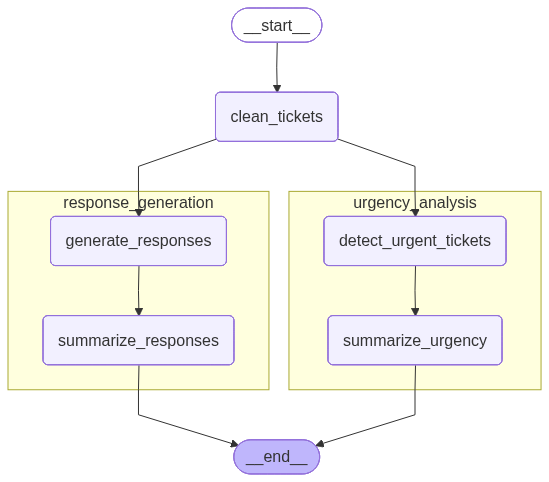

In [14]:
graph = entry_builder.compile()

from IPython.display import Image, display
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception:
    print(graph.get_graph(xray=1).draw_mermaid())


Run graph with sample input:

In [16]:
ticket1 = Ticket(
    id="T1",
    customer="Anna",
    issue="My password reset link is not working."
)

ticket2 = Ticket(
    id="T2",
    customer="Bob",
    issue="URGENT: My account is locked and needs immediate attention!"
)

raw_tickets = [ticket1, ticket2]

output = graph.invoke({"raw_tickets": raw_tickets})
import json

print(json.dumps(output, indent=2, ensure_ascii=False))


{
  "raw_tickets": [
    {
      "id": "T1",
      "customer": "Anna",
      "issue": "My password reset link is not working."
    },
    {
      "id": "T2",
      "customer": "Bob",
      "issue": "URGENT: My account is locked and needs immediate attention!"
    }
  ],
  "cleaned_tickets": [
    {
      "id": "T1",
      "customer": "Anna",
      "issue": "My password reset link is not working.",
      "response": "Reset password instructions sent."
    },
    {
      "id": "T2",
      "customer": "Bob",
      "issue": "URGENT: My account is locked and needs immediate attention!",
      "response": "We’re reviewing your issue and will respond soon."
    }
  ],
  "urgency_summary": "1 urgent tickets found needing priority handling.",
  "response_summary": "Generated 2 draft responses.",
  "processed_logs": [
    "response-generated-ticket-T1",
    "response-generated-ticket-T2",
    "urgent-analysis-ticket-T2"
  ]
}
